In [1]:
import scanpy as sc
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
import warnings
warnings.filterwarnings('ignore')

In [2]:
from utils.filehandling import buildGeneset
from utils.clustering import *
from utils.optimization import *

In [3]:
adata = sc.read("datasets/immune_adata.h5ad")

# **Separation of Immune cells** 

Import the JSON files with the marker genes of each immune type and remode the genes that do not exist to their intersection with the expressed genes of the data.  

In [4]:
with open('Genesets/Immune/BCELLS.json', 'r') as file:
    bcell_gene_set = json.load(file)
    bcell_gene_set = bcell_gene_set['genes']
    
with open('Genesets/Immune/TCELLS.json', 'r') as file:
    tcell_gene_set = json.load(file)
    tcell_gene_set = tcell_gene_set['genes']
    
with open('Genesets/Immune/MPHAGES.json','r') as file:
    mphages_gene_set = json.load(file)
    mphages_gene_set = mphages_gene_set['genes']
    
    
bcell_gene_set_final = set(adata.var_names) & set(bcell_gene_set)
print(f"Genes removed from the gene set: {len(set(bcell_gene_set) - bcell_gene_set_final)} out of {len(bcell_gene_set)}\n")

tcell_gene_set_final = set(adata.var_names) & set(tcell_gene_set)
print(f"Genes removed from the gene set: {len(set(tcell_gene_set) - tcell_gene_set_final)} out of {len(tcell_gene_set)}\n")

mphages_gene_set_final = set(adata.var_names) & set(mphages_gene_set)
print(f"Genes removed from the gene set: {len(set(mphages_gene_set) - mphages_gene_set_final)} out of {len(mphages_gene_set)}\n")

Genes removed from the gene set: 2 out of 34

Genes removed from the gene set: 2 out of 19

Genes removed from the gene set: 1 out of 33



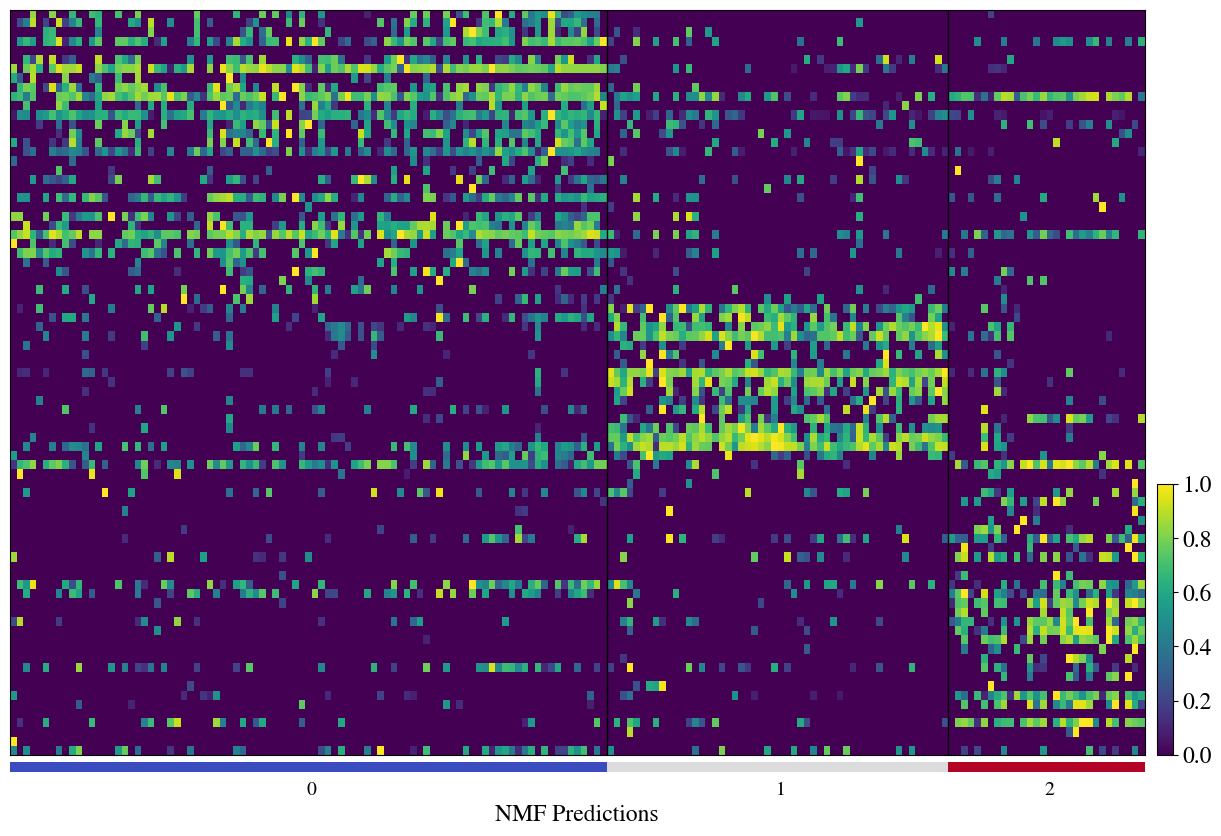

In [5]:
total_genes = list(bcell_gene_set_final) + list(tcell_gene_set_final) + list(mphages_gene_set_final)
adata = adata[:,total_genes]
sc.pl.heatmap(adata, var_names=total_genes , groupby='NMF Predictions', use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')

From the above its evident that the cluster with label 0 expresses the BCELL related geneset, cluster 1 expresses the TCELL related geneset and cluster 2 expresses the Macrophage related geneset. Thus we can name the clusters accordingly.

In [6]:
adata.obs['NMF Predictions']

BC02_60       2
BC03_03       0
BC03_06       0
BC03_24       0
BC03_25       1
             ..
BC09_Re_94    1
BC09_Re_95    1
BC10_07       2
BC10_43       2
BC11_28       1
Name: NMF Predictions, Length: 173, dtype: category
Categories (3, object): ['0', '1', '2']

In [7]:
label_mapping = {'0': "B-CELL", '1': "T-CELL", '2': "MP-CELL"}
adata.obs['NMF Predictions'] = [label_mapping[label] for label in adata.obs['NMF Predictions']]

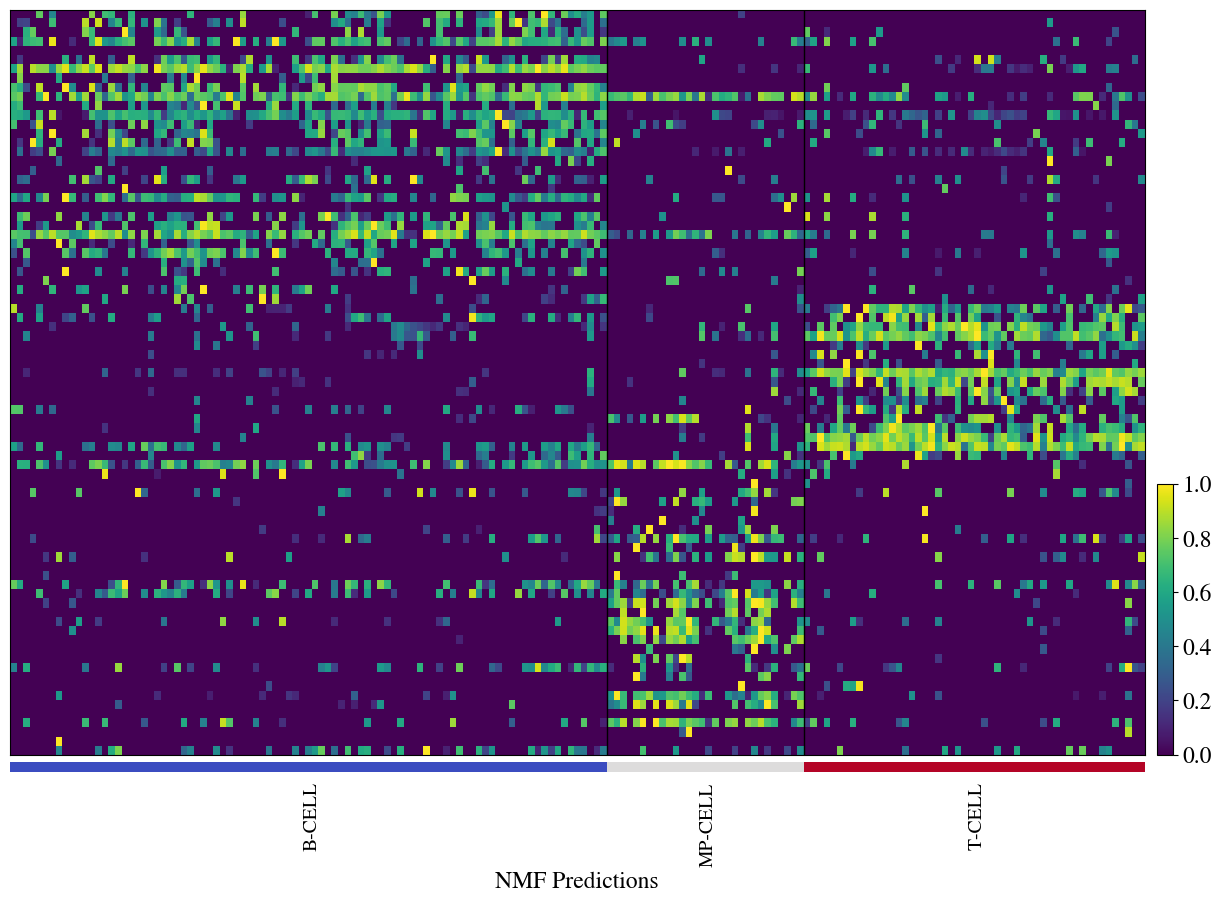

In [8]:
sc.pl.heatmap(adata, var_names=total_genes , groupby='NMF Predictions', use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')

NMF predictions per tumor groups.

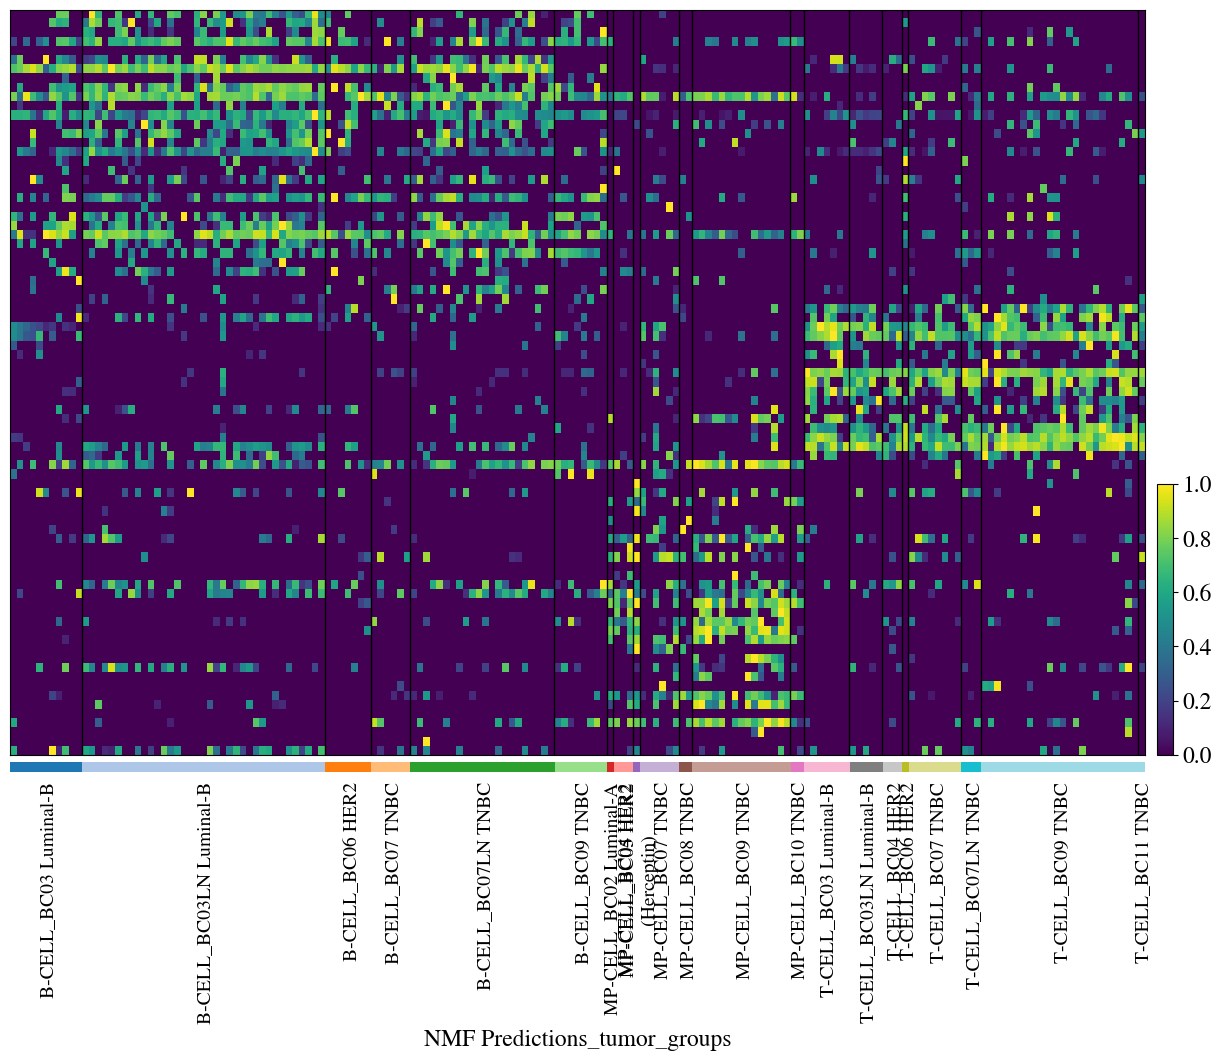

In [9]:
sc.pl.heatmap(adata, var_names=total_genes , groupby=['NMF Predictions','tumor_groups'], use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')

# **T-cell singnature pathway Clustering** 

In [23]:
import os
def buildGeneset(directory,adata):
  json_files = [file for file in os.listdir(directory) if file.endswith('.json')]
  gene_sets = {}

  for file in json_files:
      file_name = os.path.splitext(file)[0]  # Remove the file extension
      gene_set_name = file_name.split('.')[0]  # Extract the desired part of the file name
      with open(os.path.join(directory, file), 'r') as f:
          gene_set_data = json.load(f)
          # Extract the nested gene set using the appropriate key
          try:
            gene_set = gene_set_data['genes']
          except KeyError:
            gene_set = gene_set_data[gene_set_name]['geneSymbols']
          gene_set_final = set(adata.var_names) & set(gene_set)
          print(f"Genes removed from the gene set: {len(set(gene_set) - gene_set_final)} out of {len(gene_set)}\n")
          gene_sets[gene_set_name] = gene_set_final
  return gene_sets

In [27]:
total_genes=[]
gene_sets = buildGeneset('Genesets/Tcells',adata)
print(gene_sets)
for key in gene_sets.keys():
  total_genes = total_genes + list(gene_sets[key])
  # For single cell data
  sc.tl.score_genes(adata,gene_sets[key],score_name = key)
    
adata_tcells = adata[adata.obs['Ground cell type']=='Tcell', total_genes]

# Plot scingle cell data
sc.pl.heatmap(
    adata_tcells,
    var_names=list(gene_sets.keys()),
    groupby="tumor_groups",
    swap_axes=True,
    standard_scale='var',
    vmin=0,
    vmax=1,
    figsize=(16, 8)
)

['G1_S.json', 'Costimulatory.json', 'Cytotoxic.json', 'G2_M.json', 'Naïve.json', 'Regulatory.json', 'Exhausted.json']
Genes removed from the gene set: 43 out of 43

Genes removed from the gene set: 6 out of 6

Genes removed from the gene set: 7 out of 7

Genes removed from the gene set: 54 out of 55

Genes removed from the gene set: 4 out of 4

Genes removed from the gene set: 7 out of 7

Genes removed from the gene set: 6 out of 6

{'G1_S': set(), 'Costimulatory': set(), 'Cytotoxic': set(), 'G2_M': set(), 'Naïve': set(), 'Regulatory': set(), 'Exhausted': set()}


ValueError: No valid genes were passed for scoring.

### **Hierarchical: Average linkage**

In [ ]:
data = adata_tcells.X

The silhouete score in the optimal PCA space is: 0.14679360508689562


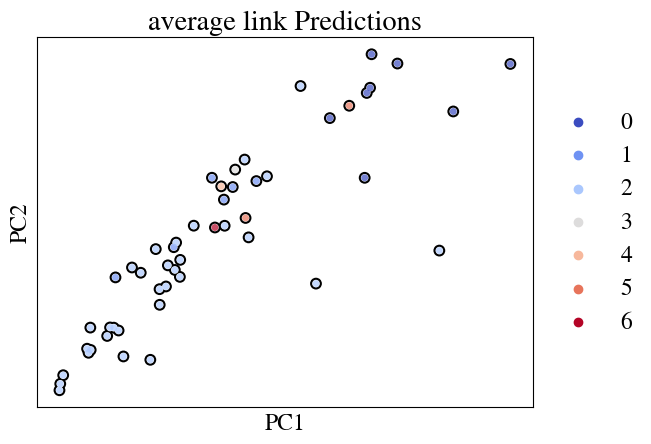

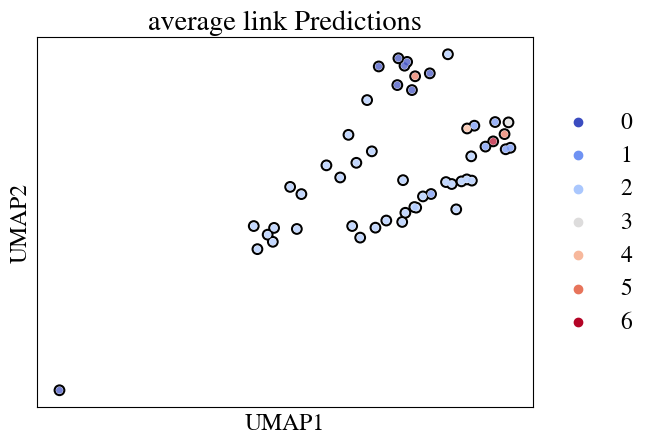

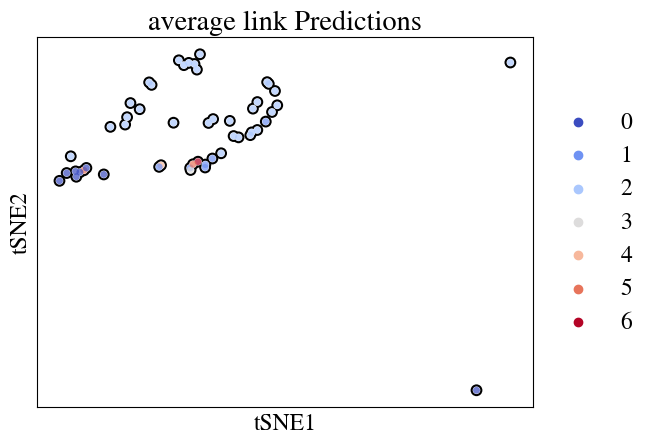

In [ ]:
ha_score = hierarchical(data,adata_tcells,'average',n_clusters=7,compare=False)

## **Spectral Clustering**

In [ ]:
def Spectral_trial(trial):
  n_neighbors = trial.suggest_int("n_neighbors",2,50)
  spectral = SpectralClustering(n_clusters=7,
                                affinity='nearest_neighbors',
                                n_neighbors=n_neighbors,
                                assign_labels="cluster_qr",
                                random_state=10)
  labels = spectral.fit_predict(data)
  try:
    return silhouette_score(data, labels, random_state=42)
  except ValueError:
  # Return the worst score if it does not converge
    return -1

pruner = optuna.pruners.HyperbandPruner()
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(Spectral_trial, n_trials=100, show_progress_bar=True)

# Get the best parameters and objective value
best_params = study.best_params
best_value = study.best_value
print(best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

{'n_neighbors': 6}


The silhouete score in the optimal PCA space is: 0.059476739959828925


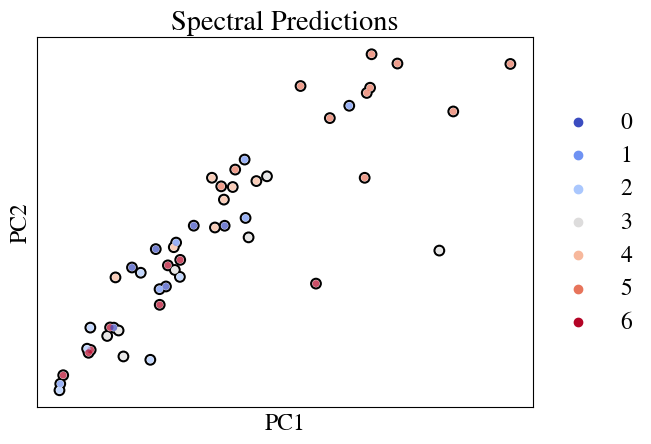

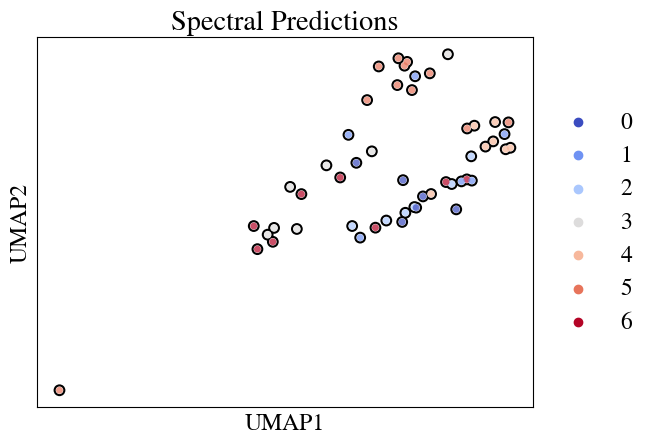

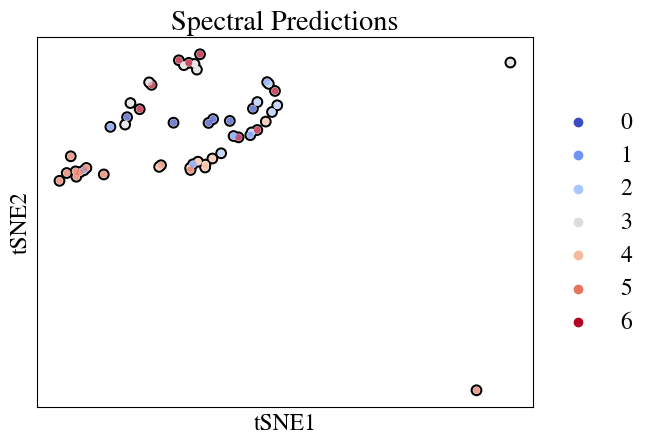

In [ ]:
sp_score = spectral(data,adata_tcells,n_neighbors=best_params['n_neighbors'],comparison_key='Ground cell type',n_clusters= 7,compare=False)

## **Hierarchical complete linkage**

The silhouete score in the optimal PCA space is: 0.09904566435617919


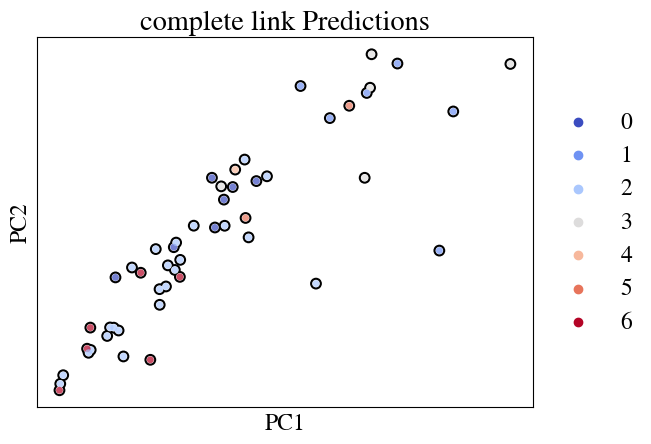

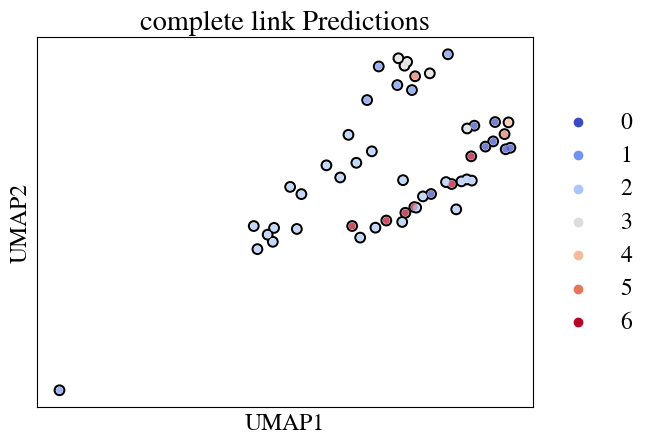

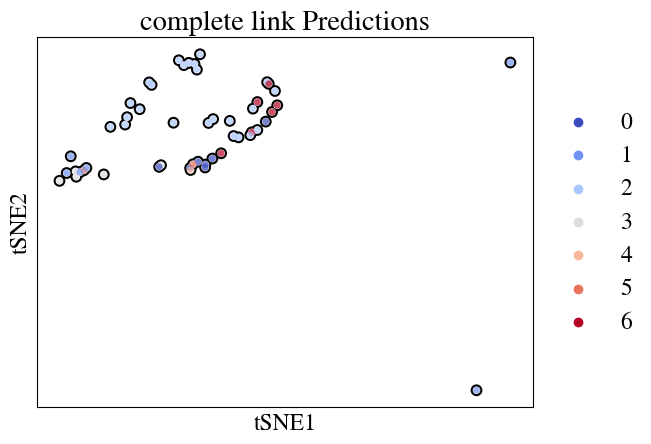

In [ ]:
hc_score = hierarchical(data,adata_tcells,'complete',n_clusters=7,compare=False)

The silhouete score in the optimal PCA space is: 0.041847946520085576


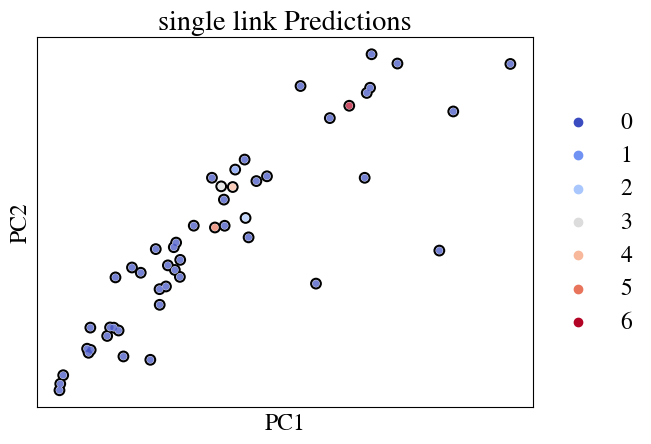

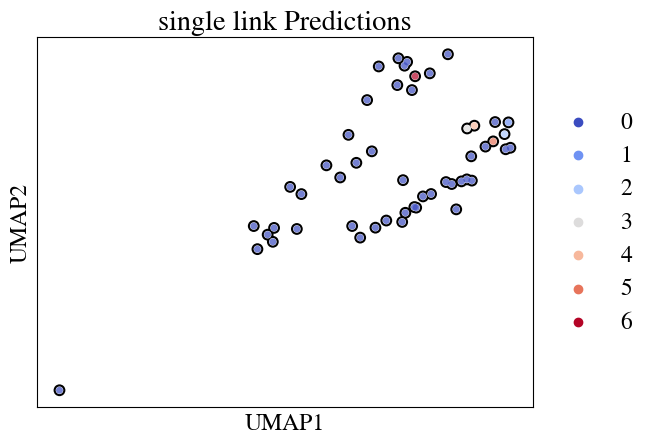

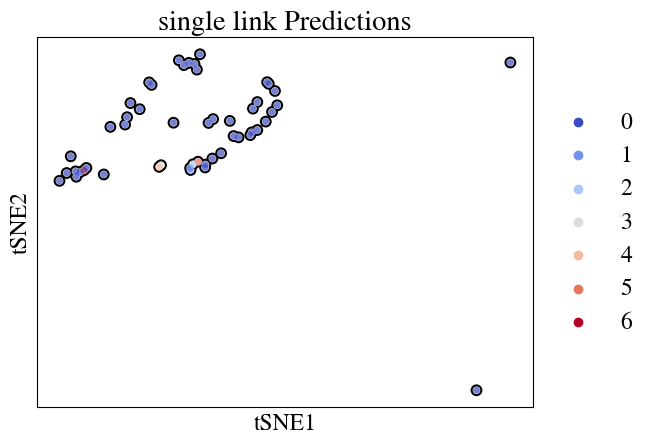

In [ ]:
hs_score = hierarchical(data,adata_tcells,'single',n_clusters=7,compare=False)

The silhouete score in the optimal PCA space is: 0.057797832912104996


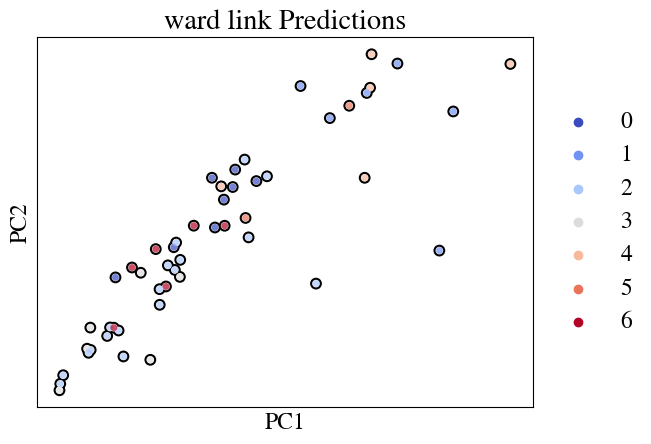

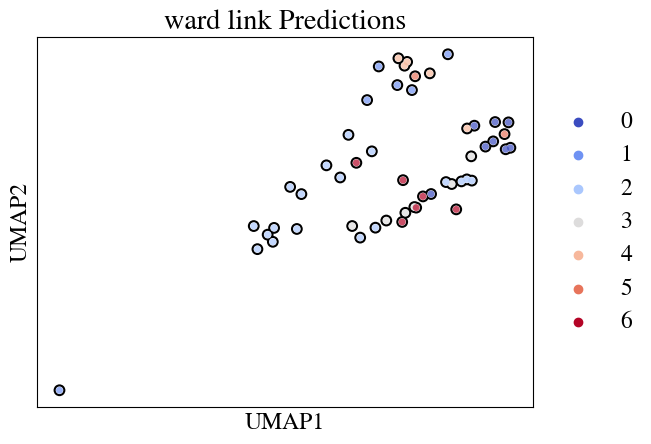

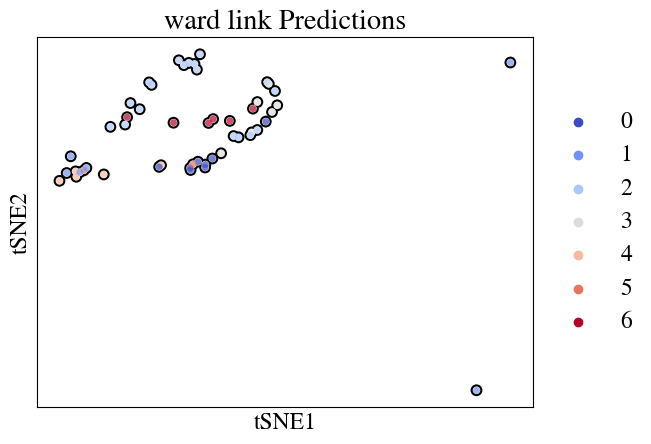

In [ ]:
hw_score = hierarchical(data,adata_tcells,'ward',n_clusters=7,compare=False)

# **Results of T-cell signature seperation**

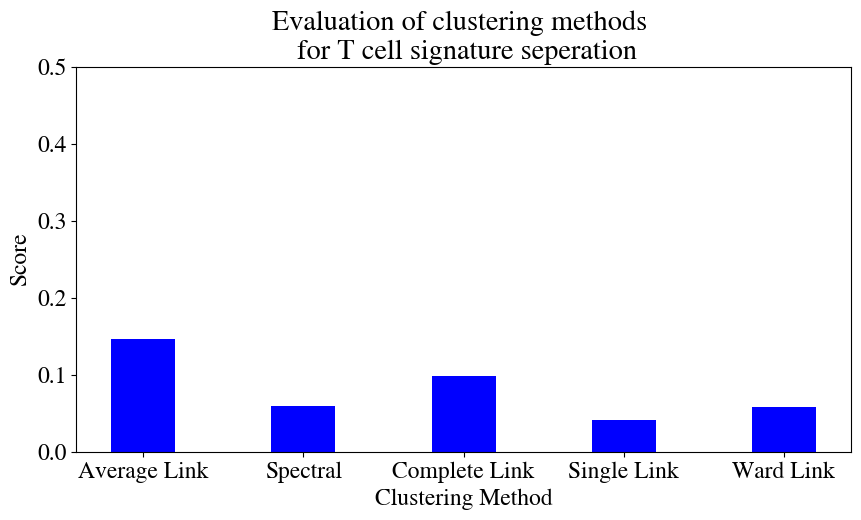

In [ ]:
results_df = pd.DataFrame({'Method':['Average Link','Spectral','Complete Link','Single Link','Ward Link'],
                        'Silhouette Score':[ha_score,sp_score, hc_score, hs_score, hw_score]})
                        

plt.figure(figsize=(10,5))
plt.bar(x = results_df['Method'], height = results_df['Silhouette Score'], color = 'blue', width = 0.4)
plt.title("Evaluation of clustering methods \n for T cell signature seperation")
plt.ylabel("Score")
plt.xlabel("Clustering Method")
plt.yticks(np.arange(0.0,0.6,0.1))
plt.show()

Hierarchical Clustering with Average Linkage resulted the highest Silhouette score, making it the chosen cluster formula for the final predictions of T cells.

# **Results heatmap**

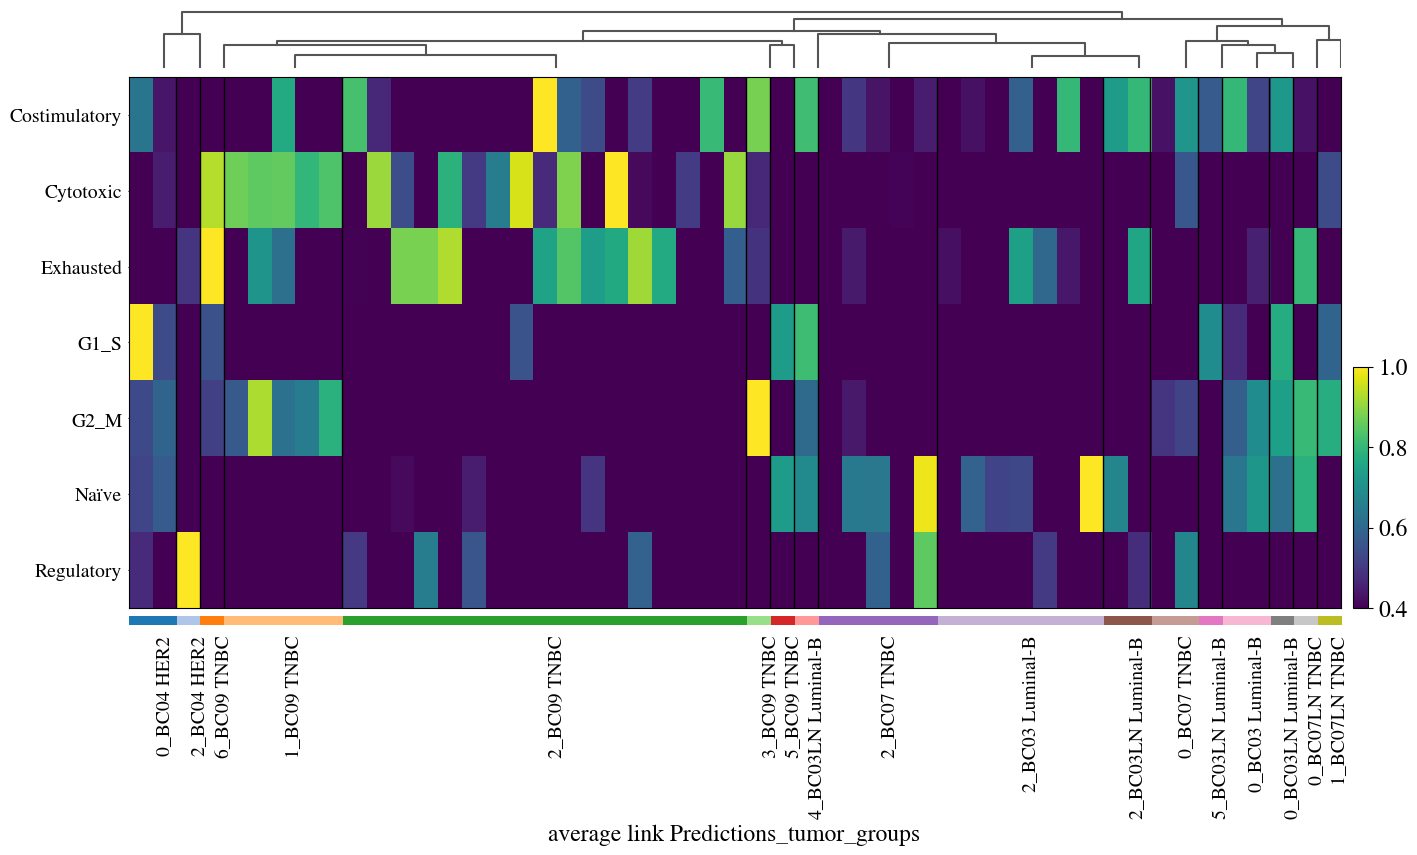

In [ ]:
sc.pl.heatmap(
    adata_tcells,
    var_names=list(gene_sets.keys()),
    groupby=[f"average link Predictions","tumor_groups"],
    swap_axes=True,
    standard_scale='var',
    dendrogram=True,
    vmin=0.4,
    vmax=1,
    figsize=(16, 8)
)